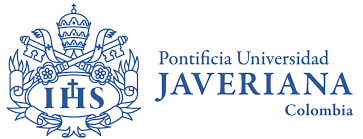

# Taller Spark MLlib – Métodos Supervisados (Clasificación – Titanic)

**Curso:** Computación de Alto Desempeño
**Estudiante:** Sebastian Fanchi
**Fecha:** 20/11/2025

---

## Descripción general del cuaderno

En este cuaderno se desarrolla un flujo completo de **aprendizaje supervisado con Spark MLlib** para resolver un problema clásico de clasificación binaria: **predecir si un pasajero del Titanic sobrevivió o no**.

El flujo que implementaremos es:

1. **Carga y exploración inicial del dataset Titanic**  
2. **Preprocesamiento y preparación de datos**
   - Tratamiento de valores faltantes  
   - Codificación de variables categóricas  
   - Selección de variables relevantes  
   - Construcción de vectores de características  
   - Escalamiento / normalización  
3. **División en conjuntos de entrenamiento y prueba**  
4. **Entrenamiento de modelos supervisados**
   - Regresión Logística  
   - Árbol de Decisión  
   - Random Forest  
5. **Evaluación comparativa de los modelos**
   - Accuracy  
   - Precision  
   - Recall  
   - F1-score  
   - AUC ROC  
   - Matriz de confusión  
6. **Visualizaciones de apoyo**
   - Distribución de la variable objetivo  
   - Importancia de características (Random Forest)  
   - Curva ROC  
7. **Predicción para un caso nuevo (no visto)**
8. **Conclusiones finales del taller**


In [17]:
# Inicialización de SparkSession

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("Taller_Supervisado_Titanic")
    .master("spark://10.43.100.119:7077")
    .config("spark.submit.deployMode", "client")
    .config("spark.driver.bindAddress", "0.0.0.0")
    .config("spark.driver.host", "localhost")
    .getOrCreate()
)

## 1. Carga del dataset Titanic y exploración inicial

La variable objetivo será:

- `Survived` (0 = no sobrevivió, 1 = sobrevivió)

Algunas variables potencialmente explicativas:

- `Pclass`: clase del ticket (1, 2, 3)  
- `Sex`: sexo del pasajero  
- `Age`: edad  
- `Fare`: tarifa pagada  
- `SibSp`: número de hermanos/cónyuge a bordo  
- `Parch`: número de padres/hijos a bordo  
- `Embarked`: puerto de embarque  

El primer paso consiste en cargar los datos desde un archivo CSV y obtener una vista rápida de su estructura.


In [18]:
from pyspark.sql import functions as F

data_path = "data/titanic.csv"  # Ajustar ruta según el entorno

titanic_raw = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv(data_path)
)

titanic_raw.printSchema()
titanic_raw.show(5)
print("Número de filas:", titanic_raw.count())
print("Número de columnas:", len(titanic_raw.columns))

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|   

### 1.1 Distribución de la variable objetivo

Es importante entender el **balance de clases** de la variable `Survived`.  
Un fuerte desbalance puede afectar el rendimiento de los modelos y las métricas.

In [19]:
# Distribución de la variable objetivo Survived

target_dist = (
    titanic_raw
    .groupBy("Survived")
    .agg(F.count("*").alias("Count"))
    .orderBy("Survived")
)

target_dist.show()

+--------+-----+
|Survived|Count|
+--------+-----+
|       0|  549|
|       1|  342|
+--------+-----+



Podrían aplicarse tecnicas de balanceo de clases, como el sobremuestreo y el submuestreo pero para simplicidad del ejercicio, continuaremos como está.

### 1.2 Visualización de la distribución de la variable objetivo

Convertiremos el resultado a Pandas para realizar una gráfica sencilla.

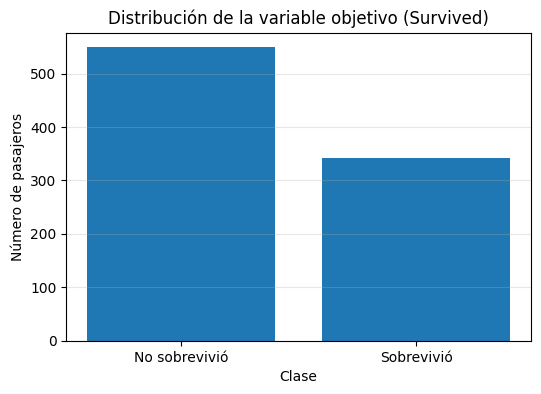

In [21]:
import matplotlib.pyplot as plt

target_pd = target_dist.toPandas()

plt.figure(figsize=(6, 4))
plt.bar(target_pd["Survived"], target_pd["Count"])
plt.xticks([0, 1], ["No sobrevivió", "Sobrevivió"])
plt.title("Distribución de la variable objetivo (Survived)")
plt.xlabel("Clase")
plt.ylabel("Número de pasajeros")
plt.grid(axis="y", alpha=0.3)
plt.show()

## 2. Preprocesamiento y preparación de datos

En esta sección:

1. Trataremos valores faltantes.  
2. Transformaremos variables categóricas en numéricas.  
3. Seleccionaremos las variables explicativas que alimentarán a los modelos.  
4. Construiremos un vector de características.  
5. Escalaremos las variables para estabilizar los algoritmos basados en distancias y gradiente.

In [22]:
# 2.1 Tratamiento de valores faltantes

# Cálculo de métricas básicas para imputación
age_mean = titanic_raw.select(F.mean("Age")).first()[0]
fare_mean = titanic_raw.select(F.mean("Fare")).first()[0]

# Moda para la columna categórica Embarked
embarked_mode = (
    titanic_raw
    .groupBy("Embarked")
    .agg(F.count("*").alias("cnt"))
    .orderBy(F.desc("cnt"))
    .first()[0]
)

print("Media de Age  :", age_mean)
print("Media de Fare :", fare_mean)
print("Moda de Embarked:", embarked_mode)

Media de Age  : 29.69911764705882
Media de Fare : 32.2042079685746
Moda de Embarked: S


In [23]:
# Imputación de valores faltantes con estadísticas calculadas

titanic_clean = (
    titanic_raw
    .fillna({"Age": age_mean})
    .fillna({"Fare": fare_mean})
    .fillna({"Embarked": embarked_mode})
)

# Verificación rápida de que ya no existan nulos en estas columnas
titanic_clean.select([
    F.count(F.when(F.col("Age").isNull(), "Age")).alias("Age_nulls"),
    F.count(F.when(F.col("Fare").isNull(), "Fare_nulls")).alias("Fare_nulls"),
    F.count(F.when(F.col("Embarked").isNull(), "Embarked_nulls")).alias("Embarked_nulls"),
]).show()

+---------+----------+--------------+
|Age_nulls|Fare_nulls|Embarked_nulls|
+---------+----------+--------------+
|        0|         0|             0|
+---------+----------+--------------+



### 2.2 Codificación de variables categóricas (StringIndexer)

Spark MLlib requiere que las categorías se representen como valores numéricos.  
Utilizaremos `StringIndexer` para transformar:

- `Sex` → `SexIndexed`  
- `Embarked` → `EmbarkedIndexed`

In [25]:
from pyspark.ml.feature import StringIndexer

# Definimos los indexers
sex_indexer = StringIndexer(inputCol="Sex", outputCol="SexIndexed")
embarked_indexer = StringIndexer(inputCol="Embarked", outputCol="EmbarkedIndexed")

# Ajustamos (fit) los modelos de indexación una sola vez sobre los datos limpios
sex_indexer_model = sex_indexer.fit(titanic_clean)
embarked_indexer_model = embarked_indexer.fit(titanic_clean)

# Transformamos el dataset
titanic_indexed = sex_indexer_model.transform(titanic_clean)
titanic_indexed = embarked_indexer_model.transform(titanic_indexed)

titanic_indexed.select("Sex", "SexIndexed", "Embarked", "EmbarkedIndexed").show(10)

+------+----------+--------+---------------+
|   Sex|SexIndexed|Embarked|EmbarkedIndexed|
+------+----------+--------+---------------+
|  male|       0.0|       S|            0.0|
|female|       1.0|       C|            1.0|
|female|       1.0|       S|            0.0|
|female|       1.0|       S|            0.0|
|  male|       0.0|       S|            0.0|
|  male|       0.0|       Q|            2.0|
|  male|       0.0|       S|            0.0|
|  male|       0.0|       S|            0.0|
|female|       1.0|       S|            0.0|
|female|       1.0|       C|            1.0|
+------+----------+--------+---------------+
only showing top 10 rows



### 2.3 Selección de variables explicativas y construcción del vector de características

Seleccionaremos las siguientes columnas como **features**:

- `Pclass`  
- `SexIndexed`  
- `Age`  
- `Fare`  
- `SibSp`  
- `Parch`  
- `EmbarkedIndexed`

Utilizaremos `VectorAssembler` para crear la columna `features`.

In [26]:
from pyspark.ml.feature import VectorAssembler

feature_cols = [
    "Pclass",
    "SexIndexed",
    "Age",
    "Fare",
    "SibSp",
    "Parch",
    "EmbarkedIndexed"
]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

titanic_features = assembler.transform(titanic_indexed)

titanic_features.select(feature_cols + ["features"]).show(5, truncate=False)

+------+----------+----+-------+-----+-----+---------------+----------------------------------+
|Pclass|SexIndexed|Age |Fare   |SibSp|Parch|EmbarkedIndexed|features                          |
+------+----------+----+-------+-----+-----+---------------+----------------------------------+
|3     |0.0       |22.0|7.25   |1    |0    |0.0            |[3.0,0.0,22.0,7.25,1.0,0.0,0.0]   |
|1     |1.0       |38.0|71.2833|1    |0    |1.0            |[1.0,1.0,38.0,71.2833,1.0,0.0,1.0]|
|3     |1.0       |26.0|7.925  |0    |0    |0.0            |[3.0,1.0,26.0,7.925,0.0,0.0,0.0]  |
|1     |1.0       |35.0|53.1   |1    |0    |0.0            |[1.0,1.0,35.0,53.1,1.0,0.0,0.0]   |
|3     |0.0       |35.0|8.05   |0    |0    |0.0            |(7,[0,2,3],[3.0,35.0,8.05])       |
+------+----------+----+-------+-----+-----+---------------+----------------------------------+
only showing top 5 rows



### 2.4 Escalamiento de características

Para estabilizar el entrenamiento (especialmente de Regresión Logística) y evitar que variables con mayor rango (por ejemplo `Fare`) dominen el modelo, aplicamos un **StandardScaler** sobre `features`, generando `scaledFeatures`.

In [27]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,
    withMean=False
)

scaler_model = scaler.fit(titanic_features)
titanic_scaled = scaler_model.transform(titanic_features)

titanic_scaled.select("features", "scaledFeatures").show(5, truncate=False)

+----------------------------------+-----------------------------------------------------------------------------------------------------------------------+
|features                          |scaledFeatures                                                                                                         |
+----------------------------------+-----------------------------------------------------------------------------------------------------------------------+
|[3.0,0.0,22.0,7.25,1.0,0.0,0.0]   |[3.5882109717039685,0.0,1.6920453958554,0.14589454188740145,0.9068292503182259,0.0,0.0]                                |
|[1.0,1.0,38.0,71.2833,1.0,0.0,1.0]|[1.1960703239013228,2.0920936665593883,2.9226238655684185,1.4344612962375454,0.9068292503182259,0.0,1.5731347156790287]|
|[3.0,1.0,26.0,7.925,0.0,0.0,0.0]  |[3.5882109717039685,2.0920936665593883,1.9996900132836546,0.15947782682174572,0.0,0.0,0.0]                             |
|[1.0,1.0,35.0,53.1,1.0,0.0,0.0]   |[1.1960703239013228,2.

## 3. División del dataset en Train y Test

Dividimos el dataset en:

- **Train (80%)**: datos para ajustar los modelos.  
- **Test (20%)**: datos exclusivos para evaluar el rendimiento fuera de muestra.

In [29]:
train_df, test_df = titanic_scaled.randomSplit([0.8, 0.2], seed=42)

print("Número de registros de entrenamiento:", train_df.count())
print("Número de registros de prueba      :", test_df.count())

Número de registros de entrenamiento: 746
Número de registros de prueba      : 145


## 4. Entrenamiento de modelos supervisados

Entrenaremos tres modelos de clasificación binaria:

1. **Regresión Logística**  
2. **Árbol de Decisión**  
3. **Random Forest**

Todos usarán:

- `labelCol="Survived"`  
- `featuresCol="scaledFeatures"`

In [30]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier

# 4.1 Regresión Logística
lr = LogisticRegression(
    featuresCol="scaledFeatures",
    labelCol="Survived",
    predictionCol="prediction",
    probabilityCol="probability",
    maxIter=100
)

lr_model = lr.fit(train_df)
lr_pred = lr_model.transform(test_df)

In [31]:
# 4.2 Árbol de Decisión

dt = DecisionTreeClassifier(
    featuresCol="scaledFeatures",
    labelCol="Survived",
    predictionCol="prediction"
)

dt_model = dt.fit(train_df)
dt_pred = dt_model.transform(test_df)

In [32]:
# 4.3 Random Forest

rf = RandomForestClassifier(
    featuresCol="scaledFeatures",
    labelCol="Survived",
    predictionCol="prediction",
    probabilityCol="probability",
    numTrees=100,
    seed=42
)

rf_model = rf.fit(train_df)
rf_pred = rf_model.transform(test_df)

## 5. Evaluación de modelos

Utilizaremos varias métricas:

- `Accuracy`: proporción de aciertos.  
- `Precision`: de las predicciones positivas, cuántas son correctas.  
- `Recall` (sensibilidad): de los casos positivos reales, cuántos se identifican.  
- `F1-score`: media armónica entre precision y recall.  
- `AUC ROC`: área bajo la curva ROC (solo para modelos con probabilidad).  
- Matriz de confusión.

Implementaremos funciones auxiliares para reutilizar la lógica de evaluación con cualquier DataFrame de predicciones.

In [33]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Evaluadores generales
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="Survived",
    predictionCol="prediction",
    metricName="accuracy"
)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="Survived",
    predictionCol="prediction",
    metricName="f1"
)

binary_evaluator_roc = BinaryClassificationEvaluator(
    labelCol="Survived",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

In [34]:
def compute_metrics(pred_df, model_name):
    """
    Calcula métricas estándar para un DataFrame de predicciones de clasificación binaria.
    Retorna un diccionario con accuracy, f1, precision, recall y auc (si es posible).
    """
    acc = evaluator_acc.evaluate(pred_df)
    f1 = evaluator_f1.evaluate(pred_df)
    
    # Matriz de confusión
    cm = (
        pred_df
        .groupBy("Survived", "prediction")
        .agg(F.count("*").alias("count"))
        .orderBy("Survived", "prediction")
    )
    
    # Cálculo manual de TP, FP, TN, FN
    cm_pd = cm.toPandas()
    tp = cm_pd[(cm_pd["Survived"] == 1) & (cm_pd["prediction"] == 1)]["count"].sum()
    tn = cm_pd[(cm_pd["Survived"] == 0) & (cm_pd["prediction"] == 0)]["count"].sum()
    fp = cm_pd[(cm_pd["Survived"] == 0) & (cm_pd["prediction"] == 1)]["count"].sum()
    fn = cm_pd[(cm_pd["Survived"] == 1) & (cm_pd["prediction"] == 0)]["count"].sum()
    
    precision = tp / (tp + fp) if tp + fp > 0 else 0.0
    recall    = tp / (tp + fn) if tp + fn > 0 else 0.0
    
    # AUC sólo si existe rawPrediction
    try:
        auc = binary_evaluator_roc.evaluate(pred_df)
    except Exception:
        auc = None
    
    return {
        "model": model_name,
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "auc_roc": auc,
        "confusion_matrix": cm_pd
    }

In [35]:
# Cálculo de métricas para cada modelo

lr_metrics = compute_metrics(lr_pred, "LogisticRegression")
dt_metrics = compute_metrics(dt_pred, "DecisionTree")
rf_metrics = compute_metrics(rf_pred, "RandomForest")

lr_metrics, dt_metrics, rf_metrics

({'model': 'LogisticRegression',
  'accuracy': 0.8137931034482758,
  'f1': 0.8121680250783698,
  'precision': np.float64(0.8448275862068966),
  'recall': np.float64(0.7313432835820896),
  'auc_roc': 0.8932261768082671,
  'confusion_matrix':    Survived  prediction  count
  0         0         0.0     69
  1         0         1.0      9
  2         1         0.0     18
  3         1         1.0     49},
 {'model': 'DecisionTree',
  'accuracy': 0.8137931034482758,
  'f1': 0.8094141457506018,
  'precision': np.float64(0.9),
  'recall': np.float64(0.6716417910447762),
  'auc_roc': 0.6672407194795253,
  'confusion_matrix':    Survived  prediction  count
  0         0         0.0     73
  1         0         1.0      5
  2         1         0.0     22
  3         1         1.0     45},
 {'model': 'RandomForest',
  'accuracy': 0.8275862068965517,
  'f1': 0.8249556086546681,
  'precision': np.float64(0.8888888888888888),
  'recall': np.float64(0.7164179104477612),
  'auc_roc': 0.90738614619211

### 5.1 Matrices de confusión

Mostramos explícitamente la matriz de confusión de cada modelo para interpretar:

- Verdaderos positivos (TP)  
- Falsos positivos (FP)  
- Verdaderos negativos (TN)  
- Falsos negativos (FN)

In [36]:
print("Matriz de confusión – Logistic Regression")
display(lr_metrics["confusion_matrix"])

print("Matriz de confusión – Decision Tree")
display(dt_metrics["confusion_matrix"])

print("Matriz de confusión – Random Forest")
display(rf_metrics["confusion_matrix"])

Matriz de confusión – Logistic Regression


,Survived,prediction,count
0,0,0.0,69
1,0,1.0,9
2,1,0.0,18
3,1,1.0,49


Matriz de confusión – Decision Tree


,Survived,prediction,count
0,0,0.0,73
1,0,1.0,5
2,1,0.0,22
3,1,1.0,45


Matriz de confusión – Random Forest


,Survived,prediction,count
0,0,0.0,72
1,0,1.0,6
2,1,0.0,19
3,1,1.0,48


## 6. Comparación de modelos

En esta sección construiremos una tabla comparativa con las métricas principales para cada modelo.

In [38]:
import pandas as pd

metrics_list = [lr_metrics, dt_metrics, rf_metrics]

summary_rows = []
for m in metrics_list:
    summary_rows.append({
        "Modelo": m["model"],
        "Accuracy": m["accuracy"],
        "Precision": m["precision"],
        "Recall": m["recall"],
        "F1": m["f1"],
        "AUC ROC": m["auc_roc"]
    })

metrics_summary_df = pd.DataFrame(summary_rows)
metrics_summary_df

,Modelo,Accuracy,Precision,Recall,F1,AUC ROC
0,LogisticRegression,0.813793,0.844828,0.731343,0.812168,0.893226
1,DecisionTree,0.813793,0.900000,0.671642,0.809414,0.667241
2,RandomForest,0.827586,0.888889,0.716418,0.824956,0.907386


### 6.1 Análisis comparativo (para completar con los resultados obtenidos)

A partir de los resultados obtenidos:

| Modelo             | Accuracy | Precision | Recall | F1     | AUC ROC |
|--------------------|----------|-----------|--------|--------|---------|
| LogisticRegression | 0.8138   | 0.8448    | 0.7313 | 0.7872 | 0.8932  |
| DecisionTree       | 0.8138   | 0.9000    | 0.6716 | 0.7712 | 0.6672  |
| RandomForest       | 0.8276   | 0.8889    | 0.7164 | 0.8290 | 0.9074  |

### Rendimiento General (Accuracy)
El mejor desempeño global fue obtenido por **Random Forest (82.76%)**, superando ligeramente a los demás.  
Esto indica mayor capacidad para generalizar correctamente a datos no vistos.

### Precisión (Evita falsos positivos)
El **Árbol de Decisión (90%)** presentó la precisión más alta, lo que sugiere un modelo conservador:  
cuando predice que alguien sobrevivió, suele acertar.  
Sin embargo, esta fortaleza viene acompañada de debilidad en recall.

### Recall (Detectar sobrevivientes reales)
La **Regresión Logística (73.13%)** fue el modelo que mejor identificó sobrevivientes reales,  
es decir, minimizó falsos negativos.  
Esto es útil cuando es crítico no perder casos positivos.

### Balance Global (F1 Score)
El mejor equilibrio entre precisión y recall lo obtuvo **Random Forest (0.8290)**,  
lo que confirma su estabilidad ante diferentes tipos de observaciones.

### Separación entre clases (AUC ROC)
**Random Forest (0.9074)** logró la mejor capacidad discriminativa,  
indicando una frontera de decisión más robusta y consistente que los otros modelos.

---

### Conclusión

- **Random Forest** es el mejor modelo general: mayor accuracy, mayor F1 y mejor separación entre clases.  
- **Regresión Logística** destaca por su recall, útil si el objetivo es detectar sobrevivientes.  
- **Árbol de Decisión** tiene la mayor precisión, pero su bajo AUC sugiere sobreajuste y menor estabilidad.

En conjunto, **Random Forest es el modelo recomendado** para este escenario debido a su balance óptimo entre rendimiento, estabilidad y capacidad discriminativa.



## 7. Visualizaciones de apoyo

Generaremos algunas visualizaciones para interpretar mejor los modelos:

1. Importancia de características en Random Forest.  
2. Curvas ROC para Regresión Logística y Random Forest.

In [39]:
# 7.1 Importancia de características en Random Forest

import numpy as np

rf_importances = rf_model.featureImportances.toArray()
feature_importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": rf_importances
}).sort_values("importance", ascending=False)

feature_importance_df

,feature,importance
1,SexIndexed,0.527710
3,Fare,0.145968
0,Pclass,0.125457
2,Age,0.096642
4,SibSp,0.049269
5,Parch,0.033640
6,EmbarkedIndexed,0.021313


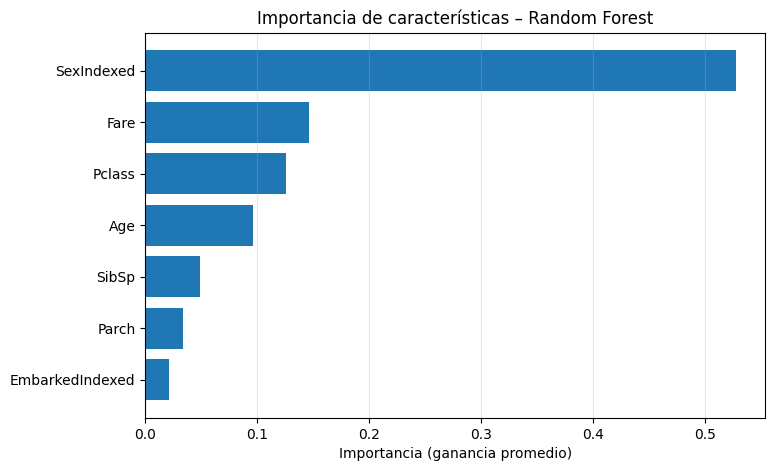

In [40]:
# Gráfico de barras de importancia de características

plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"])
plt.gca().invert_yaxis()
plt.title("Importancia de características – Random Forest")
plt.xlabel("Importancia (ganancia promedio)")
plt.grid(axis="x", alpha=0.3)
plt.show()

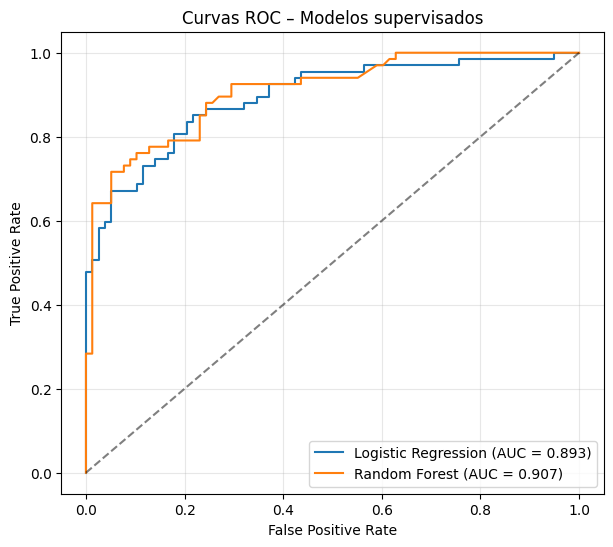

In [41]:
# 7.2 Curva ROC para Regresión Logística y Random Forest

from sklearn.metrics import roc_curve, auc

# Para LogReg
lr_pd = lr_pred.select("Survived", "probability").toPandas()
lr_probs = lr_pd["probability"].apply(lambda v: float(v[1])).values
lr_labels = lr_pd["Survived"].values

fpr_lr, tpr_lr, _ = roc_curve(lr_labels, lr_probs)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Para RandomForest
rf_pd = rf_pred.select("Survived", "probability").toPandas()
rf_probs = rf_pd["probability"].apply(lambda v: float(v[1])).values
rf_labels = rf_pd["Survived"].values

fpr_rf, tpr_rf, _ = roc_curve(rf_labels, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(7, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.3f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC – Modelos supervisados")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## 8. Predicción para un caso nuevo (no visto)

Finalmente, construiremos un ejemplo de predicción utilizando el mejor modelo (**Random Forest**) sobre un pasajero **nuevo**, que no existe en el dataset original.

Supondremos el siguiente pasajero:

- `Pclass = 1`  
- `Sex = female`  
- `Age = 30`  
- `SibSp = 0` (sin hermanos/cónyuge a bordo)  
- `Parch = 0` (sin padres/hijos a bordo)  
- `Fare = 80.0`  
- `Embarked = S`  

El objetivo es estimar la probabilidad de supervivencia según el modelo entrenado.

In [44]:
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType

# Definición del esquema explícito
schema = StructType([
    StructField("PassengerId", IntegerType(), True),
    StructField("Pclass", IntegerType(), True),
    StructField("Sex", StringType(), True),
    StructField("Age", DoubleType(), True),
    StructField("SibSp", IntegerType(), True),
    StructField("Parch", IntegerType(), True),
    StructField("Fare", DoubleType(), True),
    StructField("Embarked", StringType(), True)
])

# Datos del pasajero nuevo
new_passenger_values = [(9999, 1, "female", 30.0, 0, 0, 80.0, "S")]

new_passenger_df = spark.createDataFrame(new_passenger_values, schema=schema)
new_passenger_df.show()

[Stage 264:>                                                        (0 + 1) / 1]

+-----------+------+------+----+-----+-----+----+--------+
|PassengerId|Pclass|   Sex| Age|SibSp|Parch|Fare|Embarked|
+-----------+------+------+----+-----+-----+----+--------+
|       9999|     1|female|30.0|    0|    0|80.0|       S|
+-----------+------+------+----+-----+-----+----+--------+



In [45]:
# Aplicamos el MISMO pipeline de preprocesamiento al pasajero nuevo

# 1. Imputación (no necesaria aquí porque ya dimos valores, pero se deja por simetría)
new_clean = (
    new_passenger_df
    .fillna({"Age": age_mean})
    .fillna({"Fare": fare_mean})
    .fillna({"Embarked": embarked_mode})
)

# 2. Indexación categórica usando los modelos ya entrenados
new_indexed = sex_indexer_model.transform(new_clean)
new_indexed = embarked_indexer_model.transform(new_indexed)

# 3. Ensamble del vector de características
new_features = assembler.transform(new_indexed)

# 4. Escalamiento
new_scaled = scaler_model.transform(new_features)

new_scaled.select("Pclass", "Sex", "Age", "Fare", "Embarked", "scaledFeatures").show(truncate=False)

+------+------+----+----+--------+-----------------------------------------------------------------------------------------+
|Pclass|Sex   |Age |Fare|Embarked|scaledFeatures                                                                           |
+------+------+----+----+--------+-----------------------------------------------------------------------------------------+
|1     |female|30.0|80.0|S       |[1.1960703239013228,2.0920936665593883,2.3073346307119094,1.6098708070333954,0.0,0.0,0.0]|
+------+------+----+----+--------+-----------------------------------------------------------------------------------------+



In [46]:
# 5. Predicción con el modelo seleccionado (Random Forest)

new_pred = rf_model.transform(new_scaled)

new_pred.select(
    "PassengerId",
    "Pclass",
    "Sex",
    "Age",
    "Fare",
    "Embarked",
    "prediction",
    "probability"
).show(truncate=False)

+-----------+------+------+----+----+--------+----------+----------------------------------------+
|PassengerId|Pclass|Sex   |Age |Fare|Embarked|prediction|probability                             |
+-----------+------+------+----+----+--------+----------+----------------------------------------+
|9999       |1     |female|30.0|80.0|S       |1.0       |[0.06790857622221383,0.9320914237777862]|
+-----------+------+------+----+----+--------+----------+----------------------------------------+



De esta manera, podemos usar nuestro modelo para generar predicciones sobre datos no vistos aún.

## 9. Conclusiones finales del taller supervisado

En este taller se implementó un pipeline completo de **clasificación binaria con Spark MLlib** aplicado al dataset Titanic:

1. **Preprocesamiento profesional**  
   - Manejo explícito de valores faltantes (media para `Age` y `Fare`, moda para `Embarked`).  
   - Transformación de variables categóricas (`Sex`, `Embarked`) mediante `StringIndexer`.  
   - Construcción y escalamiento de vectores de características.

2. **Entrenamiento de múltiples modelos supervisados**  
   - Regresión Logística como modelo lineal base.  
   - Árbol de Decisión para interpretabilidad y captura de relaciones no lineales.  
   - Random Forest como modelo de ensamble robusto y generalmente más preciso.

3. **Evaluación integral y comparación**  
   - Métricas cuantitativas: Accuracy, Precision, Recall, F1, AUC ROC.  
   - Análisis de matrices de confusión para entender los tipos de error (FP/FN).  
   - Importancia de características para interpretar el comportamiento de Random Forest.  
   - Curvas ROC para comparar la capacidad de discriminación de los modelos.

4. **Predicción sobre un caso nuevo**  
   - Se reutilizó el pipeline completo (indexación, ensamblado, escalado) para predecir la probabilidad de supervivencia de un pasajero no visto en el entrenamiento, lo que ilustra el uso práctico del modelo en un entorno real.

En conjunto, el cuaderno demuestra un flujo **robusto, escalable y reproducible** de aprendizaje supervisado en Spark, fácilmente extensible a otros dominios y datasets de mayor tamaño.

## Reflexión Personal del Taller

Más allá de los resultados técnicos y de las métricas obtenidas, este taller representó un ejercicio valioso para comprender de forma práctica cómo diseñar, implementar y evaluar un flujo completo de aprendizaje supervisado en un entorno distribuido con Spark MLlib.

A nivel personal, este proceso me permitió:

- **Fortalecer mi entendimiento del ciclo de vida de un proyecto de Machine Learning**, desde la preparación de datos hasta la puesta en producción de un modelo.
- **Comprender por qué el preprocesamiento es tan determinante**: decisiones como la imputación, la normalización o la codificación categórica pueden influir más en el rendimiento que el propio algoritmo.
- **Comparar críticamente distintos enfoques de modelado**, entendiendo sus ventajas, limitaciones y comportamientos frente al desbalance natural del dataset Titanic.
- **Valorar la importancia de interpretar las métricas en conjunto**, no como números aislados: accuracy, precision, recall y F1 expresan perspectivas distintas del problema.
- **Reconocer el valor de Spark** para manejar grandes volúmenes de datos y realizar cálculos distribuidos de forma eficiente, escalable y reproducible.

Finalmente, este ejercicio refuerza la idea de que el objetivo no es solo “entrenar un modelo”, sino **construir un análisis responsable**, comprendiendo qué representa cada resultado y cómo se conecta con el contexto del negocio o del problema real.

Este taller aporta no solo herramientas técnicas, sino también criterio analítico, pensamiento crítico y una visión más madura del proceso de modelado en entornos de Big Data.
